In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score 
import nltk
nltk.download('punkt')
nltk.download("stopwords")
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.callbacks import EarlyStopping
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from sklearn.ensemble import StackingClassifier
import pickle

!pip install --upgrade xlrd
!pip install --upgrade pandas
!pip install keras.preprocessing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/spam.csv", encoding ="ISO-8859-1")


## 1. Data Cleaning

In [ ]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [ ]:
df.sample(5)

,v1,v2
1895,ham,"Uh, heads up we don't have THAT much left"
1423,ham,Lol great now im getting hungry.
3423,spam,Am new 2 club & dont fink we met yet Will B gr...
2473,ham,Ok lor wat time Ì_ finish?
4977,ham,JADE ITS PAUL. Y DIDNåÕT U TXT ME? DO U REMEMB...


In [ ]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [ ]:
df_with_ham  = df[df['target']==1]

In [ ]:

df.duplicated().sum()

403

In [ ]:

df = df.drop_duplicates(keep='first')

In [ ]:
df.duplicated().sum()

0

## 2.EDA

In [ ]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


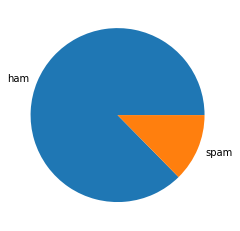

In [ ]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'])
plt.show()

In [ ]:
df['no_of_characters'] = df['text'].apply(len)

Number of Words

In [ ]:
df['no_of_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [ ]:
df.head()

,target,text,no_of_characters,no_of_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [ ]:
df['no_of_sntnc'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [ ]:
df.head()

,target,text,no_of_characters,no_of_words,no_of_sntnc
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
df[['no_of_characters','no_of_words','no_of_sntnc']].describe()

,no_of_characters,no_of_words,no_of_sntnc
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [ ]:

df[df['target'] == 0][['no_of_characters','no_of_words','no_of_sntnc']].describe()

,no_of_characters,no_of_words,no_of_sntnc
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [ ]:

df[df['target'] == 1][['no_of_characters','no_of_words','no_of_sntnc']].describe()

,no_of_characters,no_of_words,no_of_sntnc
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


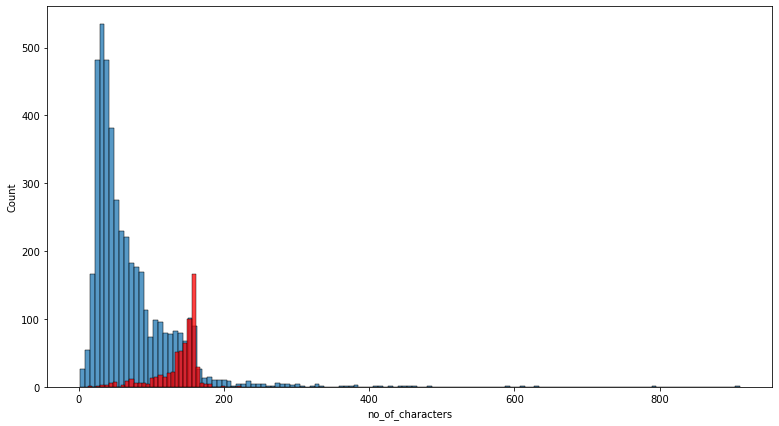

In [ ]:
plt.figure(figsize=(13,7))
sns.histplot(df[df['target'] == 0]['no_of_characters'])
sns.histplot(df[df['target'] == 1]['no_of_characters'],color='red')

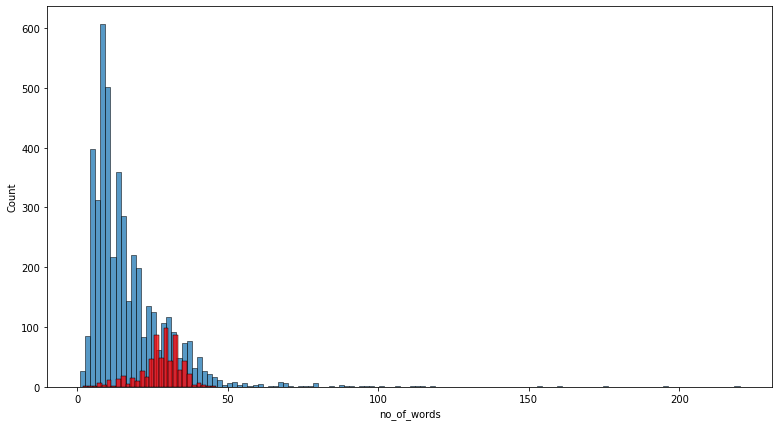

In [ ]:
plt.figure(figsize=(13,7))
sns.histplot(df[df['target'] == 0]['no_of_words'])
sns.histplot(df[df['target'] == 1]['no_of_words'],color='red')

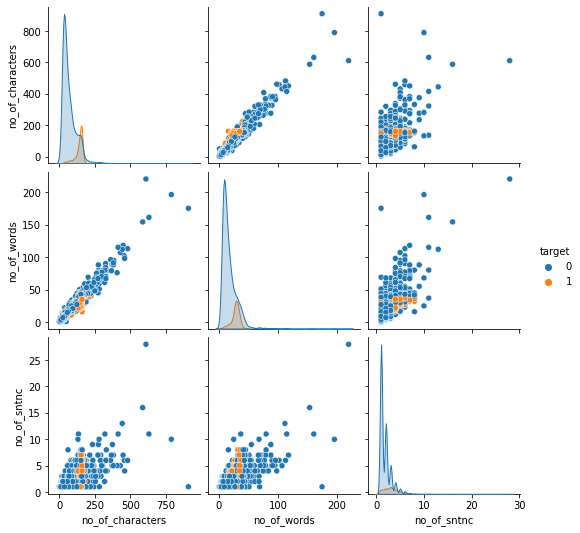

In [ ]:
sns.pairplot(df,hue='target')

In [ ]:
df.corr()

,target,no_of_characters,no_of_words,no_of_sntnc
target,1.000000,0.384717,0.262984,0.284901
no_of_characters,0.384717,1.000000,0.965770,0.638143
no_of_words,0.262984,0.965770,1.000000,0.684541
no_of_sntnc,0.284901,0.638143,0.684541,1.000000


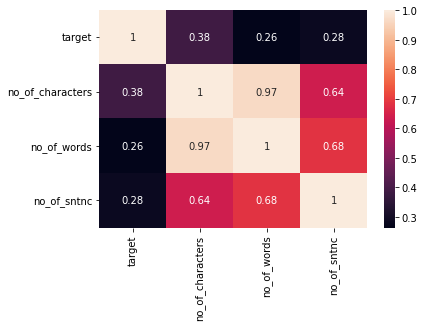

In [ ]:
sns.heatmap(df.corr(),annot=True)

## 3. Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [ ]:
def txt_trans(sentence):
    tokens = nltk.word_tokenize(sentence)    
    output = []
        
    for i in tokens:
      i=i.lower()
      if((i.isalnum()==False) or i in string.punctuation or i in stopwords.words('english')):
          continue
      output.append(PorterStemmer().stem(i))            
    return " ".join(output)
df['tt'] = df['text'].apply(txt_trans)    

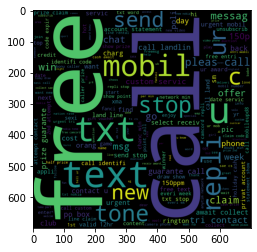

In [ ]:
img_s = WordCloud(width=700,height=700,min_font_size=6).generate(df[df['target'] == 1]['tt'].str.cat(sep=" "))
plt.imshow(img_s)

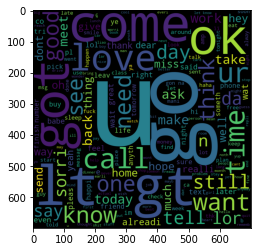

In [ ]:
img_h = WordCloud(width=700,height=700,min_font_size=6).generate(df[df['target'] == 0]['tt'].str.cat(sep=" "))
plt.imshow(img_h)

In [ ]:
words_spam = []
temp = np.array(df[df['target'] == 1]['tt'])
for i in temp:
    sp = i.split()
    for j in sp:
        words_spam.append(j)
words_ham = []
temp = np.array(df[df['target'] == 0]['tt'])
for i in temp:
    sp = i.split()
    for j in sp:
        words_ham.append(j)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


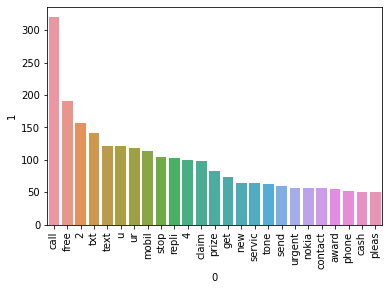

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


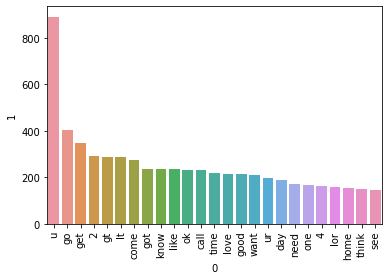

In [ ]:
x_t = pd.DataFrame(Counter(words_spam).most_common(25))[0]
y_t = pd.DataFrame(Counter(words_spam).most_common(25))[1]
sns.barplot(x_t,y_t)
plt.xticks(rotation='vertical')
plt.show()
x_t = pd.DataFrame(Counter(words_ham).most_common(25))[0]
y_t = pd.DataFrame(Counter(words_ham).most_common(25))[1]
sns.barplot(x_t,y_t)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
Counter(words_spam).most_common(20)# common words found in spam


[('call', 320),
 ('free', 191),
 ('2', 157),
 ('txt', 141),
 ('text', 122),
 ('u', 122),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('4', 99),
 ('claim', 98),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57)]

In [ ]:
Counter(words_ham).most_common(20)# common words found in ham

[('u', 892),
 ('go', 404),
 ('get', 349),
 ('2', 290),
 ('gt', 288),
 ('lt', 287),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('ok', 233),
 ('call', 233),
 ('time', 219),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165)]

In [ ]:
df.head()

,target,text,no_of_characters,no_of_words,no_of_sntnc,tt
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## 4. Model Building

In [ ]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['tt']).toarray()
y = df['target'].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.867504835589942
[[785 111]
 [ 26 112]]
0.5022421524663677


In [ ]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9729206963249516
[[896   0]
 [ 28 110]]
1.0


In [ ]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [ ]:
# tfidf --> MNB

In [ ]:
classifiers = {
    'support_vect' : SVC(kernel='sigmoid', gamma=1.0),
    'k_neighbours' : KNeighborsClassifier(), 
    'mult_NB': MultinomialNB(), 
    'dtree': DecisionTreeClassifier(max_depth=5), 
    'logs_regr': LogisticRegression(solver='liblinear', penalty='l1'), 
    'rand_forest': RandomForestClassifier(n_estimators=50, random_state=2), 
    'grad_boost':GradientBoostingClassifier(n_estimators=50,random_state=2),
}

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy,precision, precision, f1

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

temp1 = classifiers.items()

for i,j in temp1:
    
    current_accuracy,current_precision, current_recall, current_f1 = train_classifier(j, X_train,y_train,X_test,y_test)
    
    print("Classifier: ",i)
    print("Accuracy: ",current_accuracy)
    print("Precision: ",current_precision)
    print("Recall: ",current_recall)
    print("F1: ",current_f1)
    
    accuracy_scores.append(current_accuracy)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)
    precision_scores.append(current_precision)

Classifier:  support_vect
Accuracy:  0.9758220502901354
Precision:  0.9747899159663865
Recall:  0.9747899159663865
F1:  0.9027237354085604
Classifier:  k_neighbours
Accuracy:  0.9052224371373307
Precision:  1.0
Recall:  1.0
F1:  0.44943820224719105
Classifier:  mult_NB
Accuracy:  0.9729206963249516
Precision:  1.0
Recall:  1.0
F1:  0.8870967741935484
Classifier:  dtree
Accuracy:  0.9294003868471954
Precision:  0.8217821782178217
Recall:  0.8217821782178217
F1:  0.694560669456067
Classifier:  logs_regr
Accuracy:  0.9564796905222437
Precision:  0.9696969696969697
Recall:  0.9696969696969697
F1:  0.810126582278481
Classifier:  rand_forest
Accuracy:  0.9748549323017408
Precision:  0.9827586206896551
Recall:  0.9827586206896551
F1:  0.8976377952755905
Classifier:  grad_boost
Accuracy:  0.9487427466150871
Precision:  0.9381443298969072
Recall:  0.9381443298969072
F1:  0.774468085106383


In [ ]:
models_review = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores, 'Recall':recall_scores, 'F1':f1_scores}).sort_values('Precision',ascending=False)
models_review

,Algorithm,Accuracy,Precision,Recall,F1
1,k_neighbours,0.905222,1.000000,1.000000,0.449438
2,mult_NB,0.972921,1.000000,1.000000,0.887097
5,rand_forest,0.974855,0.982759,0.982759,0.897638
0,support_vect,0.975822,0.974790,0.974790,0.902724
4,logs_regr,0.956480,0.969697,0.969697,0.810127
6,grad_boost,0.948743,0.938144,0.938144,0.774468
3,dtree,0.929400,0.821782,0.821782,0.694561


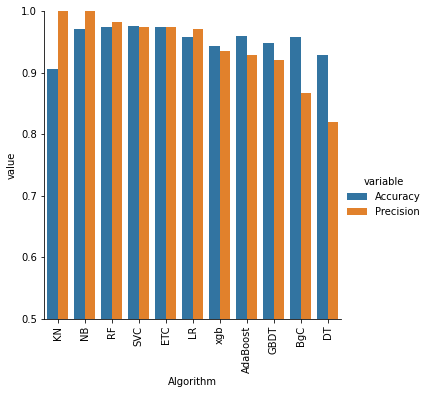

In [ ]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

## LSTM

In [ ]:
data = pd.read_csv("/content/spam.csv", encoding='latin-1')

data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
X = data.v2
Y = data.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [ ]:
word_count_maxm = 1000
len_count_maxm = 150
tokn = Tokenizer(num_words=word_count_maxm)
tokn.fit_on_texts(X_train)
sequences = tokn.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=len_count_maxm)

In [ ]:
def lstm():
    input = Input(name='inputs',shape=[len_count_maxm])
    model = Model(inputs=input,outputs= Activation('relu')(Dense(1,name='out_layer')(Dropout(0.5)( Activation('relu')(Dense(256,name='FC1')(LSTM(64)(Embedding(word_count_maxm,50,input_length=len_count_maxm)(input))))))))
    return model

In [ ]:
model = lstm()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)])

Epoch 1/5
60/60 [==============================] - 10s 133ms/step - loss: 0.2200 - accuracy: 0.9374 - val_loss: 0.0694 - val_accuracy: 0.9810
Epoch 2/5
60/60 [==============================] - 7s 122ms/step - loss: 0.0934 - accuracy: 0.9865 - val_loss: 0.0604 - val_accuracy: 0.9947


In [ ]:
test_sequences = tokn.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=len_count_maxm)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 23ms/step - loss: 0.1120 - accuracy: 0.9868


## Hyperparameter tuning using GridSearchCV

In [ ]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

In [ ]:
df2 = pd.read_csv("/content/spam.csv", encoding ="ISO-8859-1")
df2.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df2.rename(columns={'v1':'target','v2':'text'},inplace=True)

encoder = LabelEncoder()
df2['target'] = encoder.fit_transform(df2['target'])
df2['transformed_text'] = df2['text'].apply(txt_trans)

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df2['transformed_text']).toarray()
y = df2['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)


In [ ]:
model = RandomForestClassifier()
grid_space={'max_depth':[3,5,10],
              'n_estimators':[10,100,150],
              'max_features':[1,3,5,7],
           }
grid = GridSearchCV(estimator=model, param_grid=grid_space, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print("RandomForestClassifier", grid_result.best_score_, grid_result.best_params_)


RandomForestClassifier 0.8694191805901093 {'max_depth': 10, 'max_features': 7, 'n_estimators': 10}


In [ ]:
param_grid = {'max_features': ['auto', 'log2'],
              'ccp_alpha': [0.1, .001],
              'max_depth' : [ 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
print("DecisionTree", grid_search.best_score_, grid_search.best_params_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
DecisionTree 0.9095811125706492 {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto'}


In [ ]:
model =KNeighborsClassifier()
grid_space={'n_neighbors' : [1,5],
              'weights' :['uniform', 'distance'],
              'algorithm':['ball_tree', 'kd_tree']
           }
grid = GridSearchCV(estimator=model, param_grid=grid_space, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print("KNeighborsClassifier", grid_result.best_score_, grid_result.best_params_)

KNeighborsClassifier 0.9373649528328198 {'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
model =LogisticRegression()
grid_space={'penalty':['l1', 'l2', 'none'] ,
              'solver':['newton-cg', 'lbfgs', 'saga'],
              'max_iter':[5000],
              'multi_class':['ovr', 'multinomial']
           }
grid = GridSearchCV(estimator=model, param_grid=grid_space, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print("LinearRegression", grid_result.best_score_, grid_result.best_params_)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_log

LinearRegression 0.9763002856097387 {'max_iter': 5000, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'lbfgs'}
